# Setup

In [39]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

In [40]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot find name 'One'. Did you mean 'one'?": "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused",
    "Type annotations can only be used in TypeScript files." : "Type annotations",
    "A 'return' statement can only be used within a function body.": "Return outside function",
    "Property 'setState' does not exist on type 'UnicornEditor'.": "Property doesn't exist on type",
    "Top-level 'await' expressions are only allowed when the 'module' option is set to 'es2022' 'esnext' 'system' 'node16' or 'nodenext' and the 'target' option is set to 'es2017' or higher.": "Top level await",
    "Cannot find name 'it'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (it)."
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

In [41]:
#classes
class Log:
    def __init__(self, filename):
        
        rows = []
        self.snippets = None
        self.noErrors = None

        file = open(filename, encoding="utf8")
        headings = []
        csv_mode = False
        for line in file.readlines():
            line = line.strip()
            if line.startswith("ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                columns = ["".join(parts[0:-6])]
                columns += [float(p.strip()) for p in parts[-6:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

In [42]:
#load files
DATA_DIR = "../data";
SAMPLE_DIR = DATA_DIR + "/384-sample.log"
ERRORS_DIR = DATA_DIR + "/finalErrors.log"
DELETION_DIR = DATA_DIR + "/afterDeletion.log"

errors = Log(ERRORS_DIR)
deletion = Log(DELETION_DIR)

# Error Analysis

## Overview

In [43]:
errors_df = errors.errors
print("Total Snippets: " + str(errors.snippets))
print("Snippets with no Errors: " + str(errors.noErrors) + "/" + str(errors.snippets) + "(" + str(errors.noErrors/errors.snippets) + ")")
print("Snippets with Errors: " + str(errors.snippets-errors.noErrors) + "/" + str(errors.snippets) + "(" + str(1 - errors.noErrors/errors.snippets) + ")")
#there is only one snippet with a non-1 category?
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["ERROR"]))
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["FIRST ID"]))

Total Snippets: 2161911
Snippets with no Errors: 584787/2161911(0.270495408922939)
Snippets with Errors: 1577124/2161911(0.729504591077061)
['Dynamic imports can only accept a module specifier and an optional assertion as arguments']
[241928.0]


## Most common errors (occurances)

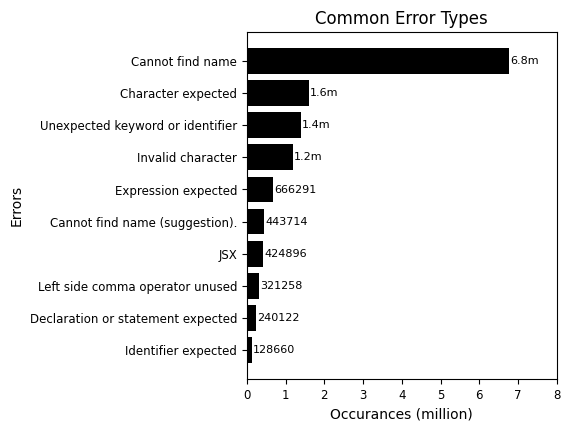

In [44]:
errors_df = errors.errors
top10_df = errors_df.nlargest(10, ['NUM OCCURANCES']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(4, 4.5)
ax1 = ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM OCCURANCES"], color="black")
ax.set_xlabel("Occurances (million)")
ax.set_ylabel("Errors")
ax.set_xlim(0, 8000000)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
ax.tick_params(axis='both', which='major', labelsize=8.5)
ax.set_title("Common Error Types")

labels = []
for n in top10_df["NUM OCCURANCES"]:
    if(n>1000000):
        n = str(round(n/1000000, 1)) + "m"
    else:
        n = int(n)
    labels.append(n)
ax.bar_label(ax1, label_type='edge', labels=labels, padding=1, size=8)
plt.savefig('commonErrorTypes', bbox_inches = "tight")
plt.show()


## Most common errors (snippets affected)

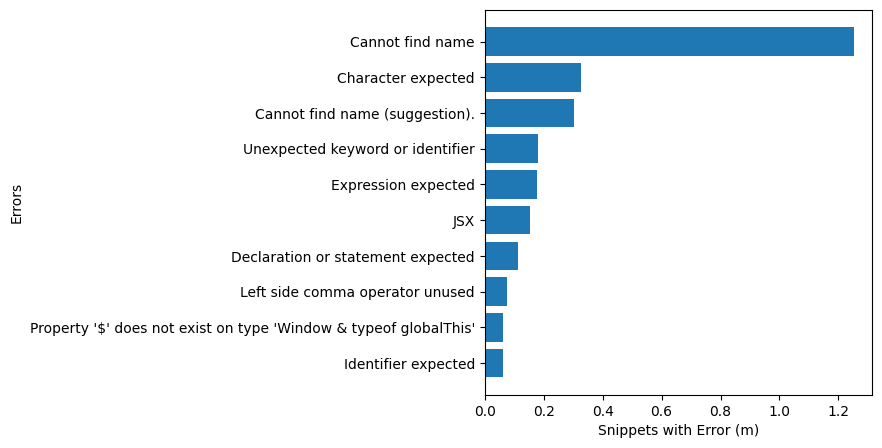

In [45]:
top10_df = errors_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000000, ',')))

# Post Deletion Analysis

## Overview

In [46]:
deletion_df = deletion.errors
print("Total Snippets: " + str(deletion.snippets))
print("Snippets with no Errors: " + str(deletion.noErrors) + "/" + str(deletion.snippets) + "(" + str(deletion.noErrors/deletion.snippets) + ")")
print("Snippets with Errors: " + str(deletion.snippets-deletion.noErrors) + "/" + str(deletion.snippets) + "(" + str(1 - deletion.noErrors/deletion.snippets) + ")")
#there is only one snippet with a non-1 category?
print(list(deletion_df[deletion_df["CATEGORY"] != 1.0]["ERROR"]))
print(list(deletion_df[deletion_df["CATEGORY"] != 1.0]["FIRST ID"]))

Total Snippets: 2161911
Snippets with no Errors: 1591310/2161911(0.7360663783106706)
Snippets with Errors: 570601/2161911(0.26393362168932943)
['Dynamic imports can only accept a module specifier and an optional assertion as arguments']
[11083.0]


## Most common errors (occurances)

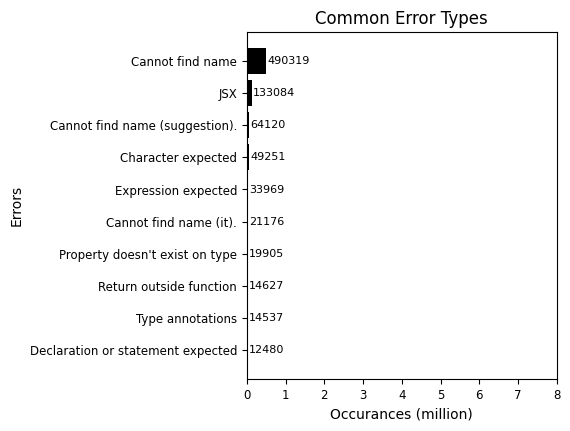

In [47]:
top10_df = deletion_df.nlargest(10, ['NUM OCCURANCES']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(4, 4.5)
ax1 = ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM OCCURANCES"], color="black")
ax.set_xlabel("Occurances (million)")
ax.set_ylabel("Errors")
ax.set_xlim(0, 8000000)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
ax.tick_params(axis='both', which='major', labelsize=8.5)
ax.set_title("Common Error Types")

labels = []
for n in top10_df["NUM OCCURANCES"]:
    if(n>1000000):
        n = str(round(n/1000000, 1)) + "m"
    else:
        n = int(n)
    labels.append(n)
ax.bar_label(ax1, label_type='edge', labels=labels, padding=1, size=8)
plt.savefig('commonErrorTypesDeletion', bbox_inches = "tight")
plt.show()


## Most common errors (snippets affected)

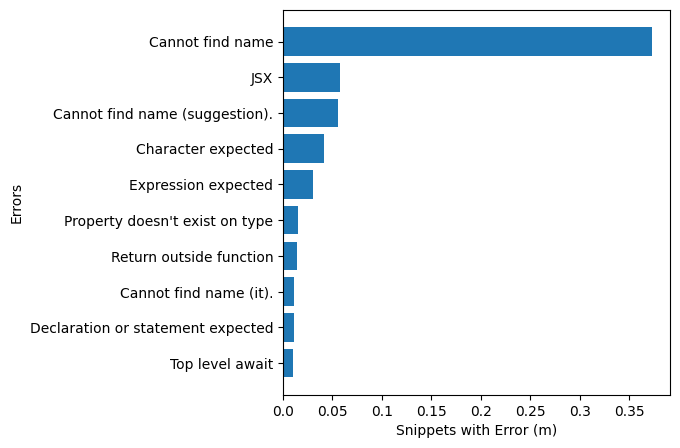

In [48]:
top10_df = deletion_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000000, ',')))